In [24]:
# Install relevant modules
!pip install demoji
!pip install transformers
!pip install Levenshtein
!pip install datasets
!pip install tensorflow
!pip install keras
# !pip install ...

In [25]:
#Loading Libraries
#For Data Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch
from wordcloud import WordCloud
import re
import demoji
import pyarrow as pa

#For Word2Vec
from collections import defaultdict  # For word frequency
from time import time
import gensim # install this package 
import cython # install this package for multi-core processing
from Levenshtein import ratio as lev_ratio
import multiprocessing
from gensim.models import Word2Vec, FastText
from gensim.models.phrases import Phrases, Phraser
import gensim.downloader as api
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer

#For NLP
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Transformers
from transformers import BertTokenizerFast
from transformers import AutoModelForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import RobertaForSequenceClassification
from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer, TFTrainer
from torch.utils.data import DataLoader, Dataset

#For Resampling
from imblearn.over_sampling import RandomOverSampler

#For Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

#RNN
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import tensorflow as tf
import keras
import scipy
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# LSTM
from datasets import Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

#Metrics and Evaluation
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

[nltk_data] Downloading package omw-1.4 to C:\Users\Shan
[nltk_data]     Shan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Shan
[nltk_data]     Shan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Shan
[nltk_data]     Shan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Shan
[nltk_data]     Shan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
#Reading preprocessed data
train_data = pd.read_csv("Processed_Train.csv", encoding = 'iso-8859-1',na_values = ['NaN', ''],parse_dates = ['TweetAt'], infer_datetime_format = True)
test_data = pd.read_csv("Processed_Test.csv", encoding = 'iso-8859-1',na_values = ['NaN', ''],parse_dates = ['TweetAt'], infer_datetime_format = True)

train_data.head()

,UserName,ScreenName,Location,TweetAt,Sentiment,NewOriginalTweet,target,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,unique_word_count,unique_vs_words
0,3800,48752,UK,2020-03-16,Positive,advice talk neighbour family exchange phone nu...,2,27,159,1,5.888889,27.0,24,0.888889
1,3801,48753,Vagabonds,2020-03-16,Positive,coronavirus australia woolworth give elderly d...,2,12,89,1,7.416667,12.0,12,1.000000
2,3802,48754,London,2020-03-16,Positive,food stock one empty please n't panic enough f...,2,16,73,1,4.562500,16.0,14,0.875000
3,3803,48755,London,2020-03-16,Negative,ready go supermarket covid19 outbreak 'm paran...,0,19,116,1,6.105263,19.0,19,1.000000
4,3804,48756,"ÃT: 36.319708,-82.363649",2020-03-16,Positive,news region first confirmed covid-19 case came...,2,25,144,1,5.760000,25.0,25,1.000000


In [27]:
train_data.isna().sum()

UserName               0
ScreenName             0
Location               0
TweetAt                0
Sentiment              0
NewOriginalTweet       0
target                 0
word_count             0
char_count             0
sentence_count         0
avg_word_length        0
avg_sentence_length    0
unique_word_count      0
unique_vs_words        0
dtype: int64

In [28]:
test_data.isna().sum()

UserName               0
ScreenName             0
Location               0
TweetAt                0
Sentiment              0
NewOriginalTweet       0
target                 0
word_count             0
char_count             0
sentence_count         0
avg_word_length        0
avg_sentence_length    0
unique_word_count      0
unique_vs_words        0
dtype: int64

In [29]:
ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(train_data.drop(["Sentiment", "target"], axis = 1), train_data['target']);
train_data = pd.concat([x_train, y_train], sort = False, axis = 1)

In [30]:
x_train = train_data['NewOriginalTweet'].values
y_train = train_data['target'].values

x_test = test_data['NewOriginalTweet'].values
y_test = test_data['target'].values

# Models 

# TF-IDF


In [31]:
vectorizer = CountVectorizer()
x_train_cv =  vectorizer.fit_transform(x_train)
x_test_cv = vectorizer.transform(x_test)

In [32]:
# TF-IDF one-hot
tf_transformer = TfidfTransformer(use_idf = True).fit(x_train_cv)
x_train_tf = tf_transformer.transform(x_train_cv)
x_test_tf = tf_transformer.transform(x_test_cv)

In [33]:
# Use x_train_tf, y_train, x_test_tf, y_test

# Naive Bayes Model

In [34]:
nb_tf = MultinomialNB()
nb_tf.fit(x_train_tf, y_train)
y_pred_nb_tf = nb_tf.predict(x_test_tf)

In [35]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test, y_pred_nb_tf, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.72      0.76      0.74      1633
     Neutral       0.58      0.53      0.55       617
    Positive       0.74      0.73      0.73      1546

    accuracy                           0.71      3796
   macro avg       0.68      0.67      0.68      3796
weighted avg       0.71      0.71      0.71      3796



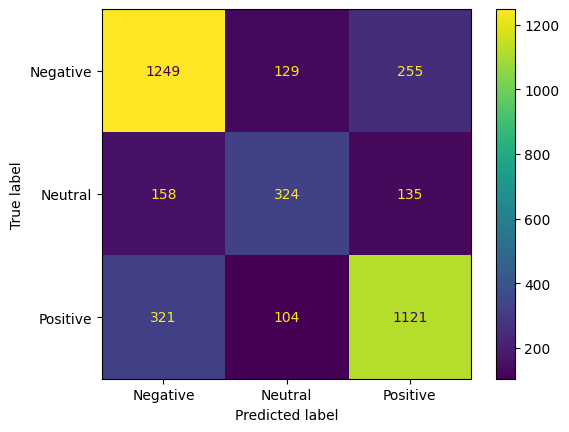

In [36]:
confusion_matrix_nb_tf = metrics.confusion_matrix(y_test, y_pred_nb_tf)
cm_display_nb_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_nb_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_nb_tf.plot()
plt.show()

# Logistic Regression Model


In [37]:
logreg_tf = LogisticRegression(random_state = 12345, max_iter = 20000, multi_class = 'multinomial')
logreg_tf.fit(x_train_tf, y_train)
y_pred_logreg_tf = logreg_tf.predict(x_test_tf) 

In [38]:
print('\tClassification Report for Logistic Regression :\n\n', classification_report(y_test, y_pred_logreg_tf, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Logistic Regression :

               precision    recall  f1-score   support

    Negative       0.83      0.77      0.80      1633
     Neutral       0.59      0.78      0.67       617
    Positive       0.83      0.79      0.81      1546

    accuracy                           0.78      3796
   macro avg       0.75      0.78      0.76      3796
weighted avg       0.79      0.78      0.78      3796



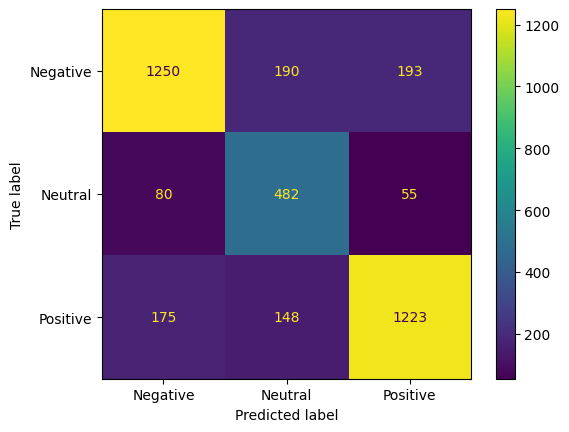

In [39]:
confusion_matrix_logreg_tf = metrics.confusion_matrix(y_test, y_pred_logreg_tf)
cm_display_logreg_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_logreg_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_logreg_tf.plot()
plt.show()

<h3>Logistic Regression Model (GridSearch) </h3>


In [40]:
param_grid_logreg_tf = {'C': [0.1, 1, 10, 100],  'penalty': ['l1', 'l2', 'elasticnet', 'none']}

logreg_tf_gridsearch = LogisticRegression()

grid_search_logreg_tf = GridSearchCV(logreg_tf_gridsearch, param_grid_logreg_tf, cv = 5)
grid_search_logreg_tf.fit(x_train_tf, y_train)
print("Best parameters: ", grid_search_logreg_tf.best_params_)
print("Best score: ", grid_search_logreg_tf.best_score_)

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

Best parameters:  {'C': 0.1, 'penalty': 'none'}
Best score:  0.8486483209018731


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
logreg_tf_gridsearch_best_param = LogisticRegression(C = grid_search_logreg_tf.best_params_['C'],
                                                    penalty = grid_search_logreg_tf.best_params_['penalty'],
                                                    random_state = 109)

logreg_tf_gridsearch_best_param.fit(x_train_tf, y_train)
y_pred_logreg_tf_gridsearch = logreg_tf_gridsearch_best_param.predict(x_test_tf)

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
print('\tClassification Report for Logistic Regression with GridSearch :\n\n', classification_report(y_test, y_pred_logreg_tf_gridsearch, target_names = ['Negative', 'Neutral', 'Positive']))                                                 

	Classification Report for Logistic Regression with GridSearch :

               precision    recall  f1-score   support

    Negative       0.85      0.76      0.80      1633
     Neutral       0.61      0.73      0.66       617
    Positive       0.82      0.84      0.83      1546

    accuracy                           0.79      3796
   macro avg       0.76      0.78      0.76      3796
weighted avg       0.80      0.79      0.79      3796



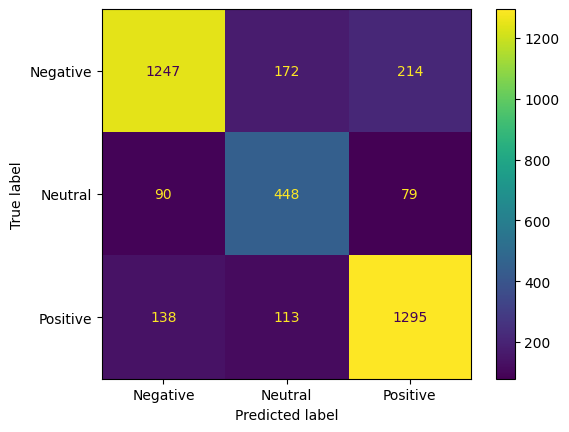

In [43]:
confusion_matrix_logreg_gridsearch_tf = metrics.confusion_matrix(y_test, y_pred_logreg_tf_gridsearch)
cm_display_logreg_gridsearch_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_logreg_gridsearch_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_logreg_gridsearch_tf.plot()
plt.show()

# Adaboost Model


In [44]:
ab_tf = AdaBoostClassifier(random_state = 12345)
ab_tf.fit(x_train_tf, y_train)
y_pred_ab_tf = ab_tf.predict(x_test_tf)

In [45]:
print('\tClassification Report for Adaboost :\n\n', classification_report(y_test, y_pred_ab_tf, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Adaboost :

               precision    recall  f1-score   support

    Negative       0.80      0.47      0.59      1633
     Neutral       0.33      0.89      0.48       617
    Positive       0.77      0.60      0.67      1546

    accuracy                           0.59      3796
   macro avg       0.63      0.65      0.58      3796
weighted avg       0.71      0.59      0.61      3796



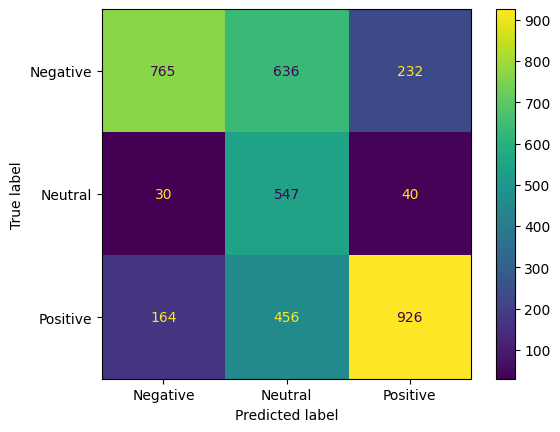

In [46]:
confusion_matrix_ab_tf = metrics.confusion_matrix(y_test, y_pred_ab_tf)
cm_display_ab_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_ab_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_ab_tf.plot()
plt.show()

<h3> Adaboost Model (GridSearch) </h3>

In [47]:
param_grid_ab_tf = { 'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}

ab_tf_gridsearch = AdaBoostClassifier(random_state = 12345)
grid_search_ab_tf = GridSearchCV(ab_tf_gridsearch, param_grid_ab_tf, cv = 5)
grid_search_ab_tf.fit(x_train_tf, y_train)
print("Best parameters: ", grid_search_ab_tf.best_params_)
print("Best score: ", grid_search_ab_tf.best_score_)

Best parameters:  {'learning_rate': 1, 'n_estimators': 150}
Best score:  0.721661723447947


In [48]:
ab_tf_gridsearch_best_param = AdaBoostClassifier(n_estimators = grid_search_ab_tf.best_params_['n_estimators'], 
                                                 learning_rate = grid_search_ab_tf.best_params_['learning_rate'],  
                                                 random_state = 109)
ab_tf_gridsearch_best_param.fit(x_train_tf, y_train)
y_pred_ab_tf_gridsearch = ab_tf_gridsearch_best_param.predict(x_test_tf)

In [49]:
print('\tClassification Report for Adaboost with GridSearch :\n\n', classification_report(y_test, y_pred_ab_tf_gridsearch, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Adaboost with GridSearch :

               precision    recall  f1-score   support

    Negative       0.81      0.61      0.70      1633
     Neutral       0.43      0.87      0.57       617
    Positive       0.79      0.67      0.73      1546

    accuracy                           0.68      3796
   macro avg       0.68      0.72      0.67      3796
weighted avg       0.74      0.68      0.69      3796



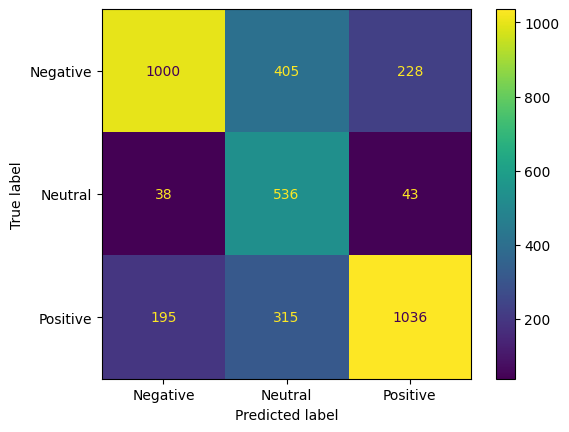

In [50]:
confusion_matrix_ab_gridsearch_tf = metrics.confusion_matrix(y_test, y_pred_ab_tf_gridsearch)
cm_display_ab_gridsearch_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_ab_gridsearch_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_ab_gridsearch_tf.plot()
plt.show()

# Gradient Boosting


In [51]:
gb_tf = GradientBoostingClassifier(random_state = 109)
gb_tf.fit(x_train_tf, y_train)
y_pred_gb_tf = gb_tf.predict(x_test_tf)

In [52]:
# Metrics
print('\tClassification Report for Gradient Boosting:\n\n',classification_report(y_test, y_pred_gb_tf, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Gradient Boosting:

               precision    recall  f1-score   support

    Negative       0.78      0.55      0.64      1633
     Neutral       0.38      0.87      0.52       617
    Positive       0.77      0.60      0.67      1546

    accuracy                           0.62      3796
   macro avg       0.64      0.67      0.61      3796
weighted avg       0.71      0.62      0.64      3796



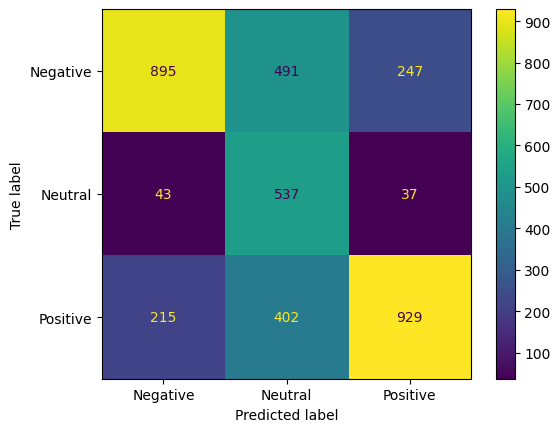

In [53]:
confusion_matrix_gb_tf = metrics.confusion_matrix(y_test, y_pred_gb_tf)
cm_display_gb_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_gb_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_gb_tf.plot()
plt.show()

<h3> Gradient Boosting (RandomizedSearchCV) </h3>

In [54]:
# Perform SVD to reduce the dimensionality of the data
svd = TruncatedSVD(n_components = 2)
x_train_tf_reduced = svd.fit_transform(x_train_tf)

# Define the parameter grid to search over
param_dist = {
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": range(50, 201, 10),
    "max_depth": range(2, 11, 1)
}

gb_cv = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions = param_dist, n_iter = 20, cv = 5)
gb_cv.fit(x_train_tf_reduced, y_train)
print("Best hyperparameter: ", gb_cv.best_params_)

Best hyperparameter:  {'n_estimators': 180, 'max_depth': 9, 'learning_rate': 0.1}


In [56]:
# Tuned Gradient Boosting

#Instantiate the model
gb_tf_cv = GradientBoostingClassifier(n_estimators = gb_cv.best_params_["n_estimators"], 
                                      max_depth = gb_cv.best_params_["max_depth"],
                                      learning_rate = gb_cv.best_params_["learning_rate"],
                                      random_state = 109)
# Train the model using the train sets
gb_tf_cv.fit(x_train_tf, y_train)

# Predict the response for test dataset
y_pred_gb_tf_cv = gb_tf_cv.predict(x_test_tf)

In [57]:
# Metrics
print('\tClassification Report for Tuned Gradient Boosting:\n\n',classification_report(y_test, y_pred_gb_tf_cv, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Tuned Gradient Boosting:

               precision    recall  f1-score   support

    Negative       0.82      0.69      0.75      1633
     Neutral       0.52      0.84      0.64       617
    Positive       0.80      0.73      0.76      1546

    accuracy                           0.73      3796
   macro avg       0.71      0.76      0.72      3796
weighted avg       0.76      0.73      0.74      3796



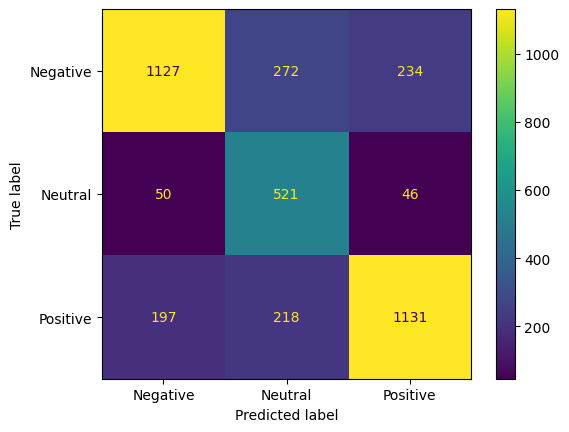

In [58]:
confusion_matrix_gb_cv_tf = metrics.confusion_matrix(y_test, y_pred_gb_tf_cv)
cm_display_gb_cv_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_gb_cv_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_gb_cv_tf.plot()
plt.show()

# XGBoost

In [59]:
#Instantiate the model
xgb_tf = XGBClassifier(random_state = 109)

# Train the model using the train sets
xgb_tf.fit(x_train_tf, y_train)

# Predict the response for test dataset
y_pred_xgb_tf = xgb_tf.predict(x_test_tf)

In [61]:
# Metrics
print('\tClassification Report for XGBoost:\n\n', classification_report(y_test, y_pred_xgb_tf, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for XGBoost:

               precision    recall  f1-score   support

    Negative       0.81      0.68      0.74      1633
     Neutral       0.49      0.84      0.62       617
    Positive       0.80      0.71      0.75      1546

    accuracy                           0.72      3796
   macro avg       0.70      0.74      0.70      3796
weighted avg       0.75      0.72      0.72      3796



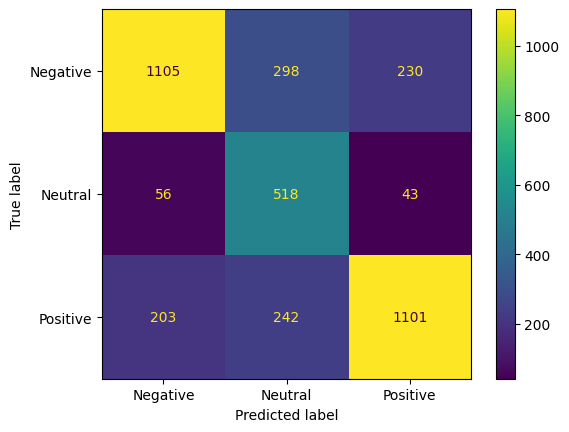

In [62]:
confusion_matrix_xgb_tf = metrics.confusion_matrix(y_test, y_pred_xgb_tf)
cm_display_xgb_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_xgb_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_xgb_tf.plot()
plt.show()

<h3> XGBoost (RandomizedSearchCV) </h3>


In [60]:
# Hyperparameter tuning 
xgb_cv = RandomizedSearchCV(XGBClassifier(), param_distributions= param_dist, n_iter = 20, cv = 5)
xgb_cv.fit(x_train_tf_reduced,y_train)
print("Best hyperparameter: ", xgb_cv.best_params_)

Best hyperparameter:  {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1}


In [63]:
# Tuned Extreme Gradient Boosting

#Instantiate the model
xgb_cv_tf = XGBClassifier(n_estimators = xgb_cv.best_params_["n_estimators"], 
                        max_depth = xgb_cv.best_params_["max_depth"], 
                        learning_rate = xgb_cv.best_params_["learning_rate"], 
                        random_state = 109)

# Train the model using the train sets
xgb_cv_tf.fit(x_train_tf, y_train)

# Predict the response for test dataset
y_pred_xgb_cv_tf = xgb_cv_tf.predict(x_test_tf)

In [64]:
# Metrics
print('\tClassification Report for Tuned XGBoost:\n\n', classification_report(y_test, y_pred_xgb_cv_tf, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Tuned XGBoost:

               precision    recall  f1-score   support

    Negative       0.80      0.67      0.73      1633
     Neutral       0.48      0.83      0.61       617
    Positive       0.80      0.70      0.75      1546

    accuracy                           0.71      3796
   macro avg       0.69      0.73      0.69      3796
weighted avg       0.75      0.71      0.72      3796



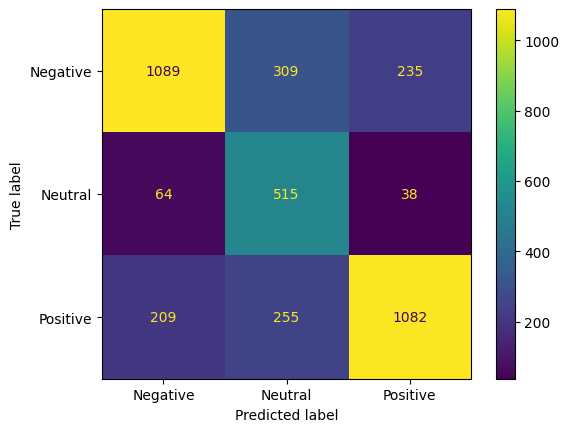

In [65]:
confusion_matrix_xgb_cv_tf = metrics.confusion_matrix(y_test, y_pred_xgb_cv_tf)
cm_display_xgb_cv_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_xgb_cv_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_xgb_cv_tf.plot()
plt.show()

# Random Forest

In [66]:
rfc_tf = RandomForestClassifier(max_depth = 15, min_samples_split = 2, n_estimators = 500)
rfc_tf.fit(x_train_tf, y_train)
y_pred_rfc_tf = rfc_tf.predict(x_test_tf)

In [67]:
print('\tClassification Report for Random Forest:\n\n', classification_report(y_test, y_pred_rfc_tf, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Random Forest:

               precision    recall  f1-score   support

    Negative       0.73      0.66      0.69      1633
     Neutral       0.42      0.75      0.54       617
    Positive       0.78      0.62      0.69      1546

    accuracy                           0.66      3796
   macro avg       0.64      0.67      0.64      3796
weighted avg       0.70      0.66      0.66      3796



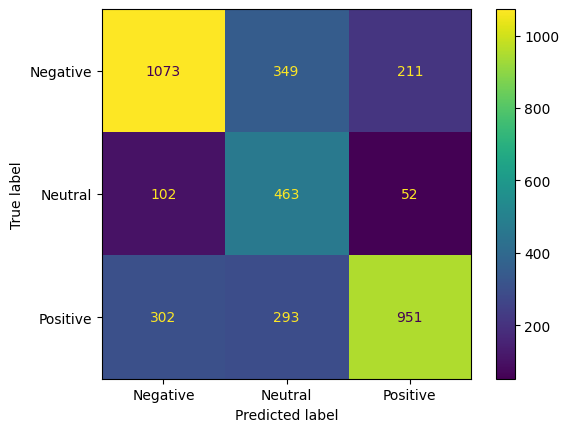

In [68]:
confusion_matrix_rfc_tf = metrics.confusion_matrix(y_test, y_pred_rfc_tf)
cm_display_rfc_tf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rfc_tf, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_rfc_tf.plot()
plt.show()

# Word2Vec Embedding

In [69]:
#Word2Vec
train_data["Corpus"] = [row.split() for row in train_data['NewOriginalTweet']]
test_data["Corpus"] = [row.split() for row in test_data["NewOriginalTweet"]]
sent = train_data["Corpus"]

# Creates the relevant phrases from the list of sentences:
phrases = Phrases(sent, min_count = 30, progress_per = 10000)
bigram = Phraser(phrases)

# Transform the corpus based on the bigrams detected:
sentences = bigram[sent]


INFO - 10:20:08: collecting all words and their counts
INFO - 10:20:08: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 10:20:09: PROGRESS: at sentence #10000, processed 171387 words and 128165 word types
INFO - 10:20:09: PROGRESS: at sentence #20000, processed 337099 words and 227163 word types
INFO - 10:20:10: PROGRESS: at sentence #30000, processed 501613 words and 318432 word types
INFO - 10:20:10: PROGRESS: at sentence #40000, processed 665998 words and 403823 word types
INFO - 10:20:10: PROGRESS: at sentence #50000, processed 806930 words and 412886 word types
INFO - 10:20:11: collected 412886 token types (unigram + bigrams) from a corpus of 856980 words and 54132 sentences
INFO - 10:20:11: merged Phrases<412886 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 10:20:11: Phrases lifecycle event {'msg': 'built Phrases<412886 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 2.56s', 'datetime': '2023-04-12T10:20:11.192467', 'gen

In [70]:
#View Cores
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

12


In [71]:
# Skipgram Models
ftmodel = FastText(min_count = 20,
                     window = 2,
                     vector_size = 200,
                     sample = 6e-5, 
                     alpha = 0.03, 
                     min_alpha = 0.0007, 
                     negative = 20,
                     workers = cores-1,
                     sg = 1)

INFO - 10:20:13: FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=200, alpha=0.03>', 'datetime': '2023-04-12T10:20:13.408013', 'gensim': '4.3.1', 'python': '3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}


In [72]:
# Show some examples of the processed words after lemmtization, stopword removal and addition of bigrams.
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

39124

In [73]:
# Words sorted by frequency 
sorted(word_freq, key = word_freq.get, reverse = True)[:10]

['coronavirus',
 'covid-19',
 'supermarket',
 'price',
 'food',
 'people',
 'grocery_store',
 'covid',
 'consumer',
 'ha']

In [74]:
t = time()
ftmodel.build_vocab(sentences)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:20:19: collecting all words and their counts
INFO - 10:20:19: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:20:19: PROGRESS: at sentence #10000, processed 161548 words, keeping 16680 word types
INFO - 10:20:19: PROGRESS: at sentence #20000, processed 318276 words, keeping 25097 word types
INFO - 10:20:20: PROGRESS: at sentence #30000, processed 474693 words, keeping 32120 word types
INFO - 10:20:20: PROGRESS: at sentence #40000, processed 630968 words, keeping 38480 word types
INFO - 10:20:20: PROGRESS: at sentence #50000, processed 764583 words, keeping 39124 word types
INFO - 10:20:21: collected 39124 word types from a corpus of 811765 raw words and 54132 sentences
INFO - 10:20:21: Creating a fresh vocabulary
INFO - 10:20:21: FastText lifecycle event {'msg': 'effective_min_count=20 retains 4516 unique words (11.54% of original 39124, drops 34608)', 'datetime': '2023-04-12T10:20:21.138132', 'gensim': '4.3.1', 'python': '3.10.7 (tags/v3.10.7:6cc6

Time to build vocab: 0.11 mins


In [75]:
t = time()
ftmodel.train(sentences, total_examples = ftmodel.corpus_count, epochs = 30, report_delay = 1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


INFO - 10:20:25: FastText lifecycle event {'msg': 'training model with 11 workers on 4516 vocabulary and 200 features, using sg=1 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2023-04-12T10:20:25.644278', 'gensim': '4.3.1', 'python': '3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
INFO - 10:20:26: EPOCH 0 - PROGRESS: at 4.47% examples, 17168 words/s, in_qsize 19, out_qsize 0
INFO - 10:20:27: EPOCH 0 - PROGRESS: at 38.28% examples, 70079 words/s, in_qsize 22, out_qsize 0
INFO - 10:20:28: EPOCH 0 - PROGRESS: at 67.76% examples, 82527 words/s, in_qsize 22, out_qsize 0
INFO - 10:20:29: EPOCH 0: training on 811765 raw words (355692 effective words) took 3.5s, 101078 effective words/s
INFO - 10:20:31: EPOCH 1 - PROGRESS: at 3.34% examples, 5420 words/s, in_qsize 13, out_qsize 0
INFO - 10:20:32: EPOCH 1 - PROGRESS: at 26.37% examples, 29565 words/s, in_qsize 19, out_qsize

Time to train the model: 1.66 mins


In [76]:
# FastText model
def ft_vec(sent):
    
    # Get the vectors for each word
    vectors = []
    for token in sent:
        vector = ftmodel.wv.get_vector(token)
        vectors.append(vector)
    
    # Average the vectors to generate a document or sentence embedding
    embedding = np.sum(vectors, axis = 0) / len(vectors)
    
    return embedding


In [77]:
train_data["ftvec"] = train_data["Corpus"].apply(ft_vec)
test_data["ftvec"] = test_data["Corpus"].apply(ft_vec)

In [78]:
x_train_ft = train_data["ftvec"].to_list()
y_train_ft = train_data["target"].to_list()

x_test_ft = test_data["ftvec"].to_list()
y_test_ft = test_data["target"].to_list()


In [79]:
# Use x_train_ft, y_train_ft, x_test_ft, y_test_ft

# Logistic Regression Model

In [80]:
logreg_ft = LogisticRegression(random_state = 12345, max_iter = 20000, multi_class = 'multinomial')
logreg_ft.fit(x_train_ft, y_train_ft)
y_pred_logreg_ft = logreg_ft.predict(x_test_ft) 

In [81]:
print('\tClassification Report for Logistic Regression :\n\n', classification_report(y_test_ft, y_pred_logreg_ft, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Logistic Regression :

               precision    recall  f1-score   support

    Negative       0.67      0.63      0.65      1633
     Neutral       0.35      0.60      0.44       617
    Positive       0.70      0.54      0.61      1546

    accuracy                           0.59      3796
   macro avg       0.57      0.59      0.57      3796
weighted avg       0.63      0.59      0.60      3796



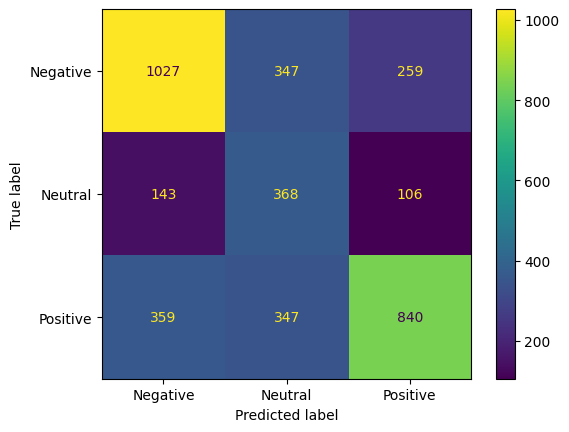

In [82]:
confusion_matrix_logreg_ft = metrics.confusion_matrix(y_test_ft, y_pred_logreg_ft)
cm_display_logreg_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_logreg_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_logreg_ft.plot()
plt.show()

<h3> Logistic Regression Model (GridSearch) </h3>

In [83]:
param_grid_logreg_ft = {'C': [0.1, 1, 10, 100],  'penalty': ['l1', 'l2', 'elasticnet', 'none']}

logreg_ft_gridsearch = LogisticRegression()

grid_search_logreg_ft = GridSearchCV(logreg_ft_gridsearch, param_grid_logreg_ft, cv = 5)
grid_search_logreg_ft.fit(x_train_ft, y_train_ft)
print("Best parameters: ", grid_search_logreg_ft.best_params_)
print("Best score: ", grid_search_logreg_ft.best_score_)

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

Best parameters:  {'C': 10, 'penalty': 'l2'}
Best score:  0.6053905509641746


In [84]:
logreg_ft_gridsearch_best_param = LogisticRegression(C = grid_search_logreg_tf.best_params_['C'],
                                                    penalty = grid_search_logreg_tf.best_params_['penalty'],
                                                    random_state = 109)
logreg_ft_gridsearch_best_param.fit(x_train_ft, y_train_ft)
y_pred_logreg_ft_gridsearch = logreg_ft_gridsearch_best_param.predict(x_test_ft)

In [85]:
print('\tClassification Report for Logistic Regression with GridSearch :\n\n', classification_report(y_test_ft, y_pred_logreg_ft_gridsearch, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Logistic Regression with GridSearch :

               precision    recall  f1-score   support

    Negative       0.67      0.63      0.65      1633
     Neutral       0.35      0.59      0.44       617
    Positive       0.70      0.54      0.61      1546

    accuracy                           0.59      3796
   macro avg       0.57      0.59      0.57      3796
weighted avg       0.63      0.59      0.60      3796



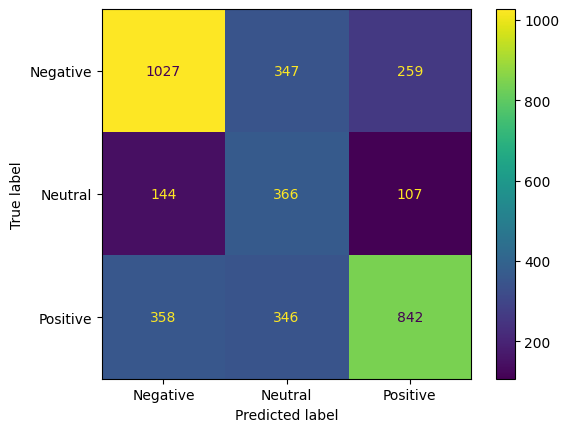

In [86]:
confusion_matrix_logreg_gridsearch_ft = metrics.confusion_matrix(y_test_ft, y_pred_logreg_ft_gridsearch)
cm_display_logreg_gridsearch_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_logreg_gridsearch_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_logreg_gridsearch_ft.plot()
plt.show()

# Adaboost Model

In [87]:
ab_ft = AdaBoostClassifier(random_state = 12345)
ab_ft.fit(x_train_ft, y_train_ft)
y_pred_ab_ft = ab_ft.predict(x_test_ft)

In [88]:
print('\tClassification Report for Adaboost :\n\n', classification_report(y_test_ft, y_pred_ab_ft, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Adaboost :

               precision    recall  f1-score   support

    Negative       0.61      0.57      0.59      1633
     Neutral       0.40      0.55      0.46       617
    Positive       0.58      0.53      0.55      1546

    accuracy                           0.55      3796
   macro avg       0.53      0.55      0.54      3796
weighted avg       0.56      0.55      0.55      3796



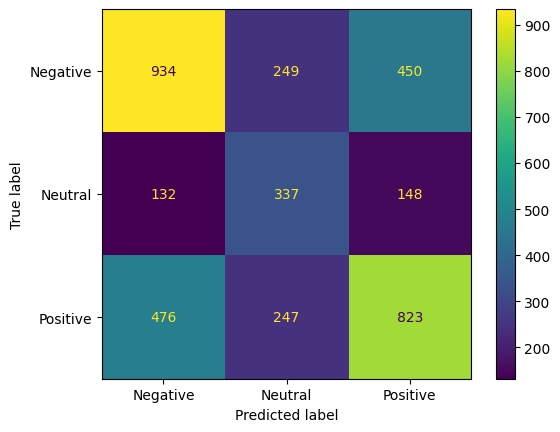

In [89]:
confusion_matrix_ab_ft = metrics.confusion_matrix(y_test_ft, y_pred_ab_ft)
cm_display_ab_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_ab_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_ab_ft.plot()
plt.show()

<h3> Adaboost Model (GridSearch) </h3>

In [90]:
param_grid_ab_ft = { 'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}

ab_ft_gridsearch = AdaBoostClassifier(random_state = 12345)
grid_search_ab_ft = GridSearchCV(ab_ft_gridsearch, param_grid_ab_ft, cv = 5)
grid_search_ab_ft.fit(x_train_ft, y_train_ft)
print("Best parameters: ", grid_search_ab_tf.best_params_)
print("Best score: ", grid_search_ab_tf.best_score_)

Best parameters:  {'learning_rate': 1, 'n_estimators': 150}
Best score:  0.721661723447947


In [96]:
ab_ft_gridsearch_best_param = AdaBoostClassifier(n_estimators = grid_search_ab_tf.best_params_['n_estimators'], 
                                                 learning_rate = grid_search_ab_tf.best_params_['learning_rate'],  
                                                 random_state = 109)
ab_ft_gridsearch_best_param.fit(x_train_ft, y_train_ft)
y_pred_ab_ft_gridsearch = ab_ft_gridsearch_best_param.predict(x_test_ft)

In [97]:
print('\tClassification Report for Adaboost with GridSearch :\n\n', classification_report(y_test_ft, y_pred_ab_ft_gridsearch, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Adaboost with GridSearch :

               precision    recall  f1-score   support

    Negative       0.62      0.62      0.62      1633
     Neutral       0.44      0.53      0.48       617
    Positive       0.61      0.56      0.58      1546

    accuracy                           0.58      3796
   macro avg       0.56      0.57      0.56      3796
weighted avg       0.59      0.58      0.58      3796



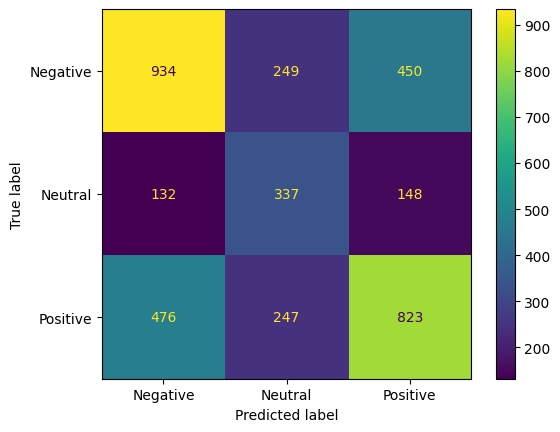

In [98]:
confusion_matrix_ab_gridsearch_ft = metrics.confusion_matrix(y_test_ft, y_pred_ab_ft)
cm_display_ab_gridsearch_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_ab_gridsearch_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_ab_gridsearch_ft.plot()
plt.show()

# Gradient Boosting

In [91]:
# Instantiate teh model
gb = GradientBoostingClassifier(random_state = 109)

# Train the model using the train sets
gb.fit(x_train_ft, y_train_ft)

# Predict the response for test dataset
y_pred_gb_ft = gb.predict(x_test_ft)

In [99]:
# Metrics
print('\tClassification Report for Gradient Boosting:\n\n', classification_report(y_test_ft, y_pred_gb_ft, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Gradient Boosting:

               precision    recall  f1-score   support

    Negative       0.64      0.68      0.66      1633
     Neutral       0.47      0.54      0.50       617
    Positive       0.65      0.58      0.61      1546

    accuracy                           0.61      3796
   macro avg       0.59      0.60      0.59      3796
weighted avg       0.62      0.61      0.61      3796



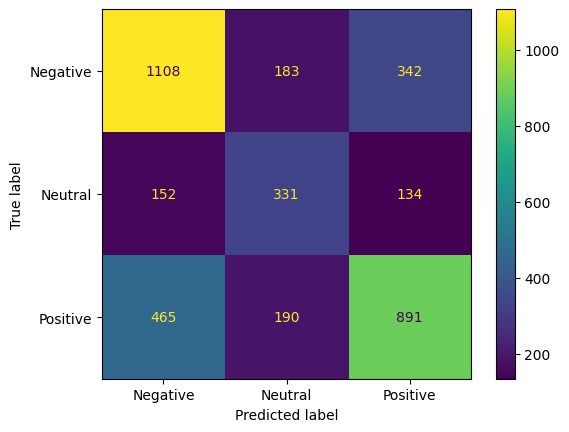

In [100]:
confusion_matrix_gb_ft = metrics.confusion_matrix(y_test_ft, y_pred_gb_ft)
cm_display_gb_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_gb_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_gb_ft.plot()
plt.show()

<h3> Gradient Boosting (RandomizedCV) </h3>



In [92]:
# Perform SVD to reduce the dimensionality of the data
svd = TruncatedSVD(n_components = 2)
x_train_ft_reduced = svd.fit_transform(x_train_ft)

# Define the parameter grid to search over
param_dist = {
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": range(50, 201, 10),
    "max_depth": range(2, 11, 1)
}

gb_cv_ft = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions = param_dist, n_iter = 20, cv = 5)
gb_cv_ft.fit(x_train_ft_reduced, y_train_ft)
print("Best hyperparameter: ", gb_cv_ft.best_params_)

Best hyperparameter:  {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.1}


In [101]:
# Tuned Gradient Boosting

#Instantiate the model
gb_ft_cv = GradientBoostingClassifier(n_estimators = gb_cv.best_params_["n_estimators"],
                                max_depth = gb_cv.best_params_["max_depth"],
                                learning_rate = gb_cv.best_params_["learning_rate"],
                                random_state = 109)
# Train the model using the train sets
gb_ft_cv.fit(x_train_ft, y_train_ft)

# Predict the response for test dataset
y_pred_gb_ft_cv = gb_ft_cv.predict(x_test_ft)

In [102]:
# Metrics
print('\tClassification Report for Tuned Gradient Boosting:\n\n', classification_report(y_test_ft, y_pred_gb_ft_cv, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Tuned Gradient Boosting:

               precision    recall  f1-score   support

    Negative       0.67      0.69      0.68      1633
     Neutral       0.64      0.40      0.49       617
    Positive       0.63      0.70      0.66      1546

    accuracy                           0.65      3796
   macro avg       0.65      0.60      0.61      3796
weighted avg       0.65      0.65      0.64      3796



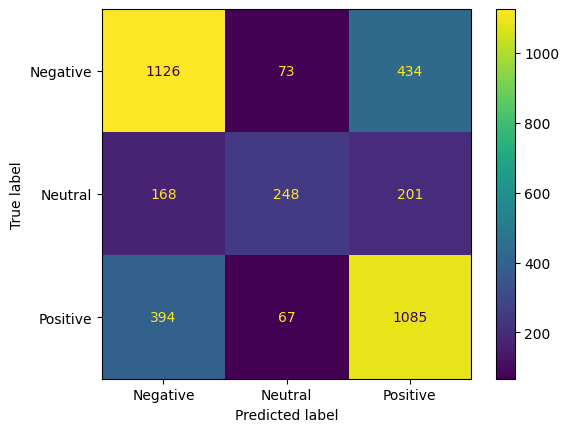

In [103]:
confusion_matrix_gb_ft_cv = metrics.confusion_matrix(y_test_ft, y_pred_gb_ft_cv)
cm_display_gb_ft_cv = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_gb_ft_cv, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_gb_ft_cv.plot()
plt.show()

# XGBoost


In [93]:
#Instantiate the model
xgb_ft = XGBClassifier(random_state = 109)

# Train the model using the train sets
xgb_ft.fit(x_train_ft, y_train_ft)
 
# Predict the response for test dataset
y_pred_xgb_ft = xgb_ft.predict(x_test_ft)

In [104]:
# Metrics
print('\tClassification Report for XGBoost:\n\n', classification_report(y_test_ft, y_pred_xgb_ft, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for XGBoost:

               precision    recall  f1-score   support

    Negative       0.66      0.70      0.68      1633
     Neutral       0.55      0.52      0.53       617
    Positive       0.66      0.64      0.65      1546

    accuracy                           0.65      3796
   macro avg       0.63      0.62      0.62      3796
weighted avg       0.64      0.65      0.64      3796



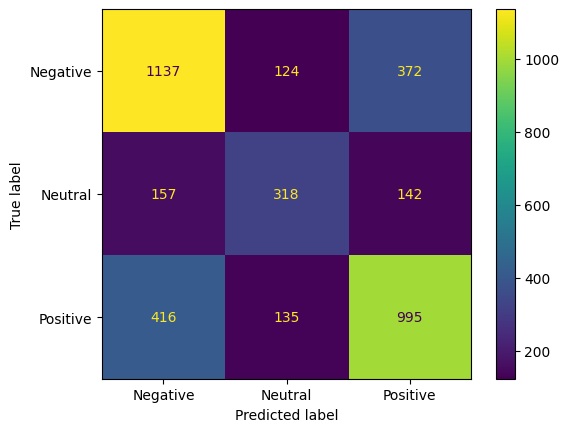

In [105]:
confusion_matrix_xgb_ft = metrics.confusion_matrix(y_test_ft, y_pred_xgb_ft)
cm_display_xgb_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_xgb_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_xgb_ft.plot()
plt.show()

<h3> XGBoost (RandomizedSearchCV)

In [94]:
# Hyperparameter tuning 
svd = TruncatedSVD(n_components = 2)
x_train_ft_reduced = svd.fit_transform(x_train_ft)

# Define the parameter grid to search over
param_dist = {
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": range(50, 201, 10),
    "max_depth": range(2, 11, 1)
}

xgb_cv_ft = RandomizedSearchCV(XGBClassifier(), param_distributions = param_dist, n_iter = 20, cv = 5)
xgb_cv_ft.fit(x_train_ft_reduced, y_train_ft)
print("Best hyperparameter: ", xgb_cv_ft.best_params_)

Best hyperparameter:  {'n_estimators': 90, 'max_depth': 10, 'learning_rate': 0.1}


In [106]:
# Tuned Extreme Gradient Boosting

#Instantiate the model
xgb_ft_cv = XGBClassifier(n_estimators = xgb_cv.best_params_["n_estimators"],
                    max_depth = xgb_cv.best_params_["max_depth"],
                    learning_rate = xgb_cv.best_params_["learning_rate"],
                    random_state = 109)

# Train the model using the train sets
xgb_ft_cv.fit(x_train_ft, y_train_ft)

# Predict the response for test dataset
y_pred_xgb_cv_ft = xgb_ft_cv.predict(x_test_ft)

In [107]:
# Metrics
print('\tClassification Report for Tuned XGBoost:\n\n',classification_report(y_test_ft, y_pred_xgb_cv_ft, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Tuned XGBoost:

               precision    recall  f1-score   support

    Negative       0.67      0.68      0.68      1633
     Neutral       0.58      0.42      0.49       617
    Positive       0.63      0.68      0.65      1546

    accuracy                           0.64      3796
   macro avg       0.63      0.60      0.61      3796
weighted avg       0.64      0.64      0.64      3796



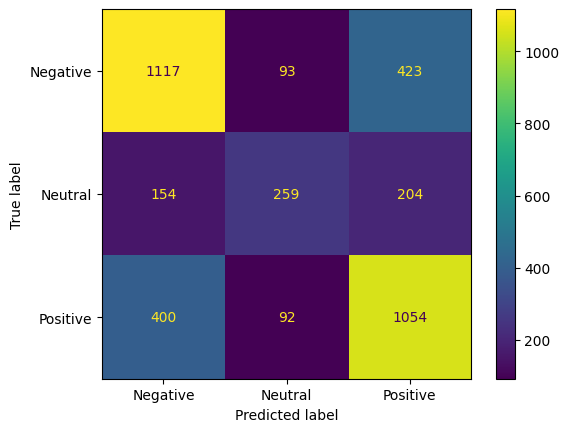

In [108]:
confusion_matrix_xgb_cv_ft = metrics.confusion_matrix(y_test_ft, y_pred_xgb_cv_ft)
cm_display_xgb_cv_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_xgb_cv_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_xgb_cv_ft.plot()
plt.show()

# Random Forest

In [95]:
rfc_ft = RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=500)
rfc_ft.fit(x_train_ft,y_train_ft)

y_pred_rfc_ft = rfc_ft.predict(x_test_ft) 

In [109]:
print('\tClassification Report for Random Forest w2v :\n\n',classification_report(y_test, y_pred_rfc_ft, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Random Forest w2v :

               precision    recall  f1-score   support

    Negative       0.62      0.67      0.64      1633
     Neutral       0.58      0.37      0.45       617
    Positive       0.61      0.64      0.62      1546

    accuracy                           0.61      3796
   macro avg       0.60      0.56      0.57      3796
weighted avg       0.61      0.61      0.60      3796



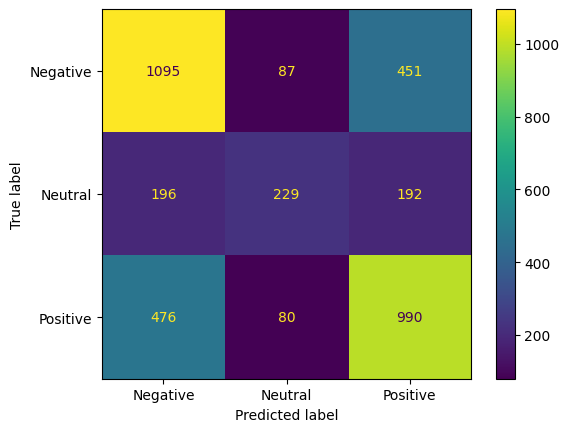

In [110]:
confusion_matrix_rfc_ft = metrics.confusion_matrix(y_test, y_pred_rfc_ft)
cm_display_rfc_ft = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rfc_ft, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_rfc_ft.plot()
plt.show()

# Bert & Roberta

In [45]:
MAX_LEN = 128
batch_size = 32

In [46]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3,problem_type="single_label_classification")


roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=3,problem_type="single_label_classification")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [47]:
def tokenize(row, max_len = MAX_LEN) :
  '''
  Just adding the label and text into bert encodings
  '''
  text = row.NewOriginalTweet  
  encodings = tokenizer(text,padding='max_length',truncation=True,max_length = max_len)
  label = row.target
  encodings['label'] = label
  encodings['text'] = text

  return encodings

def tokenize_roberta(row, max_len = MAX_LEN) :
  '''
  Just adding the label and text into bert encodings
  '''
  text = row.NewOriginalTweet  
  encodings = roberta_tokenizer.encode_plus(text,padding='max_length',truncation=True,max_length = max_len)
  label = row.target
  encodings['label'] = label
  encodings['text'] = text

  return encodings

In [48]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Bert

In [49]:
# Bert Processing
bert_data_train = []
for i in range(len(train_data)) :
  bert_data_train.append(tokenize(train_data.iloc[i]))

bert_data_test = []
for i in range(len(test_data)) :
  bert_data_test.append(tokenize(test_data.iloc[i]))

  0%|          | 0/54 [01:28<?, ?it/s]


In [50]:
bert_traindf = pd.DataFrame(bert_data_train)
bert_testdf = pd.DataFrame(bert_data_test)

bert_train, bert_valid = train_test_split(bert_traindf, test_size = 0.33, random_state = 12345)

In [51]:
hg_train_bert = Dataset.from_pandas(bert_train)
hg_valid_bert = Dataset.from_pandas(bert_valid)
hg_test_bert = Dataset.from_pandas(bert_testdf)

In [52]:
# Training arguments 
args_bert = TrainingArguments(
    "./output/bert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 2,
    weight_decay = 1e-8,
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    push_to_hub = False,
    optim = "adamw_torch",
)

trainer_bert = Trainer(
    model = bert_model,
    args = args_bert,
    train_dataset = hg_train_bert,
    eval_dataset = hg_valid_bert,
    compute_metrics = compute_metrics,
)

In [53]:
trainer_bert.train()

 29%|██▉       | 500/1722 [30:32<1:14:36,  3.66s/it]



                                                    


 29%|██▉       | 500/1722 [30:32<1:14:36,  3.66s/it]

{'loss': 0.7227, 'learning_rate': 7.0963995354239265e-06, 'epoch': 0.58}


 50%|█████     | 861/1722 [52:38<52:53,  3.69s/it]  



                                                  
                                              


 50%|█████     | 861/1722 [59:54<52:53,  3.69s/it]

{'eval_loss': 0.5195258259773254, 'eval_accuracy': 0.8101694915254237, 'eval_f1': 0.8074480222727201, 'eval_precision': 0.811233161768886, 'eval_recall': 0.8101694915254237, 'eval_runtime': 436.0458, 'eval_samples_per_second': 31.121, 'eval_steps_per_second': 0.975, 'epoch': 1.0}


 58%|█████▊    | 1000/1722 [1:08:35<44:12,  3.67s/it]   



                                                     


 58%|█████▊    | 1000/1722 [1:08:35<44:12,  3.67s/it]

{'loss': 0.5257, 'learning_rate': 4.192799070847851e-06, 'epoch': 1.16}


 87%|████████▋ | 1500/1722 [1:39:23<13:39,  3.69s/it]



                                                     


 87%|████████▋ | 1500/1722 [1:39:23<13:39,  3.69s/it]

{'loss': 0.4438, 'learning_rate': 1.289198606271777e-06, 'epoch': 1.74}


100%|██████████| 1722/1722 [1:53:00<00:00,  3.66s/it]



                                                     
                                              


100%|██████████| 1722/1722 [2:00:19<00:00,  3.66s/it]

{'eval_loss': 0.47854888439178467, 'eval_accuracy': 0.8326455416359617, 'eval_f1': 0.8320378042612075, 'eval_precision': 0.832070192166959, 'eval_recall': 0.8326455416359617, 'eval_runtime': 439.1708, 'eval_samples_per_second': 30.899, 'eval_steps_per_second': 0.968, 'epoch': 2.0}






                                                     


100%|██████████| 1722/1722 [2:00:21<00:00,  4.19s/it]

{'train_runtime': 7221.7605, 'train_samples_per_second': 7.63, 'train_steps_per_second': 0.238, 'train_loss': 0.5466171734285964, 'epoch': 2.0}


TrainOutput(global_step=1722, training_loss=0.5466171734285964, metrics={'train_runtime': 7221.7605, 'train_samples_per_second': 7.63, 'train_steps_per_second': 0.238, 'train_loss': 0.5466171734285964, 'epoch': 2.0})

In [54]:
trainer_bert.evaluate()

100%|██████████| 425/425 [07:18<00:00,  1.03s/it]


{'eval_loss': 0.47854888439178467,
 'eval_accuracy': 0.8326455416359617,
 'eval_f1': 0.8320378042612075,
 'eval_precision': 0.832070192166959,
 'eval_recall': 0.8326455416359617,
 'eval_runtime': 439.2209,
 'eval_samples_per_second': 30.896,
 'eval_steps_per_second': 0.968,
 'epoch': 2.0}

In [55]:
pred_bert = np.argmax(trainer_bert.predict(test_dataset=hg_test_bert).predictions, axis = 1)

100%|██████████| 119/119 [02:03<00:00,  1.04s/it]


In [56]:
true_labels = np.array([row["label"] for row in hg_test_bert])

In [57]:
print('\tClassification Report for BERT :\n\n', classification_report(true_labels, pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT :

               precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      1633
     Neutral       0.78      0.75      0.76       617
    Positive       0.84      0.85      0.84      1546

    accuracy                           0.83      3796
   macro avg       0.82      0.81      0.81      3796
weighted avg       0.83      0.83      0.83      3796



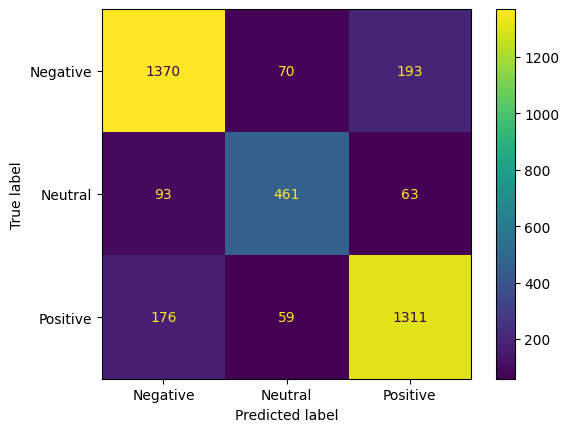

In [58]:
confusion_matrix_bert = metrics.confusion_matrix(true_labels, pred_bert)
cm_display_bert = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_bert, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_bert.plot()
plt.show()

In [59]:
output_model_file_bert = 'pytorch_bert_sentiment.bin'
output_vocab_file_bert = './'

model_to_save_bert = bert_model
torch.save(model_to_save_bert, output_model_file_bert)
tokenizer.save_vocabulary(output_vocab_file_bert)

print('All files saved')

All files saved


## Roberta

In [60]:
#Roberta Processing

rob_train = []
for i in range(len(train_data)) :
  rob_train.append(tokenize_roberta(train_data.iloc[i]))

rob_test = []
for i in range(len(test_data)) :
  rob_test.append(tokenize_roberta(test_data.iloc[i]))

In [61]:
roberta_traindf = pd.DataFrame(rob_train)
roberta_testdf = pd.DataFrame(rob_test)

rob_train, rob_valid = train_test_split(roberta_traindf, test_size=0.33, random_state=12345)

In [62]:
rob_train

,attention_mask,input_ids,label,text
6042,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 611, 3141, 2753, 2957, 260, 705, 19473, 23...",2,chinesewuhanvirus pandemic one benefit smoker ...
24774,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 13718, 368, 405, 5504, 5230, 285, 2443, 20...",2,prioritises streaming public announcement proh...
10895,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 27737, 13908, 357, 36377, 1056, 1903, 2132...",2,probably deleted better optic focus helping af...
3673,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 9902, 17083, 358, 2797, 2792, 855, 602, 38...",0,boycott every corner shop currently taking pis...
14950,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 438, 1417, 808, 12, 1646, 4829, 5286, 265,...",2,covid-19 formed academic business progress sha...
...,...,...,...,...
4094,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 12782, 876, 2996, 8534, 186, 4356, 7497, 2...",2,tesco delivery slot week im elderly much sayin...
19876,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 31666, 266, 2489, 1412, 47268, 808, 12, 16...",2,consumer report ha created covid-19 resource h...
2177,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38597, 689, 388, 1152, 961, 224, 3158, 137...",1,enough food stock product everyone say ministr...
11749,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 37111, 2542, 168, 1649, 10656, 1330, 34377...",2,please aware government check scam related cor...


In [63]:
hg_train_robert = Dataset.from_pandas(rob_train)
hg_valid_robert = Dataset.from_pandas(rob_valid)
hg_test_robert = Dataset.from_pandas(roberta_testdf)

In [64]:
# Roberta Training Arguments

args_robert = TrainingArguments(
    "./output/robert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=1e-8,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    optim="adamw_torch",
)

trainer_robert = Trainer(
    model=roberta_model,
    args=args_robert,
    train_dataset=hg_train_robert,
    eval_dataset=hg_valid_robert,
    compute_metrics = compute_metrics,
)



In [65]:
trainer_robert.train()

 29%|██▉       | 500/1722 [31:05<1:15:58,  3.73s/it]



                                                    


 29%|██▉       | 500/1722 [31:05<1:15:58,  3.73s/it]

{'loss': 0.7566, 'learning_rate': 7.0963995354239265e-06, 'epoch': 0.58}


 50%|█████     | 861/1722 [53:33<53:37,  3.74s/it]  



                                                    
                                              


 50%|█████     | 861/1722 [1:00:48<53:37,  3.74s/it]

{'eval_loss': 0.5407084226608276, 'eval_accuracy': 0.7984524686809138, 'eval_f1': 0.7965508470861056, 'eval_precision': 0.8006709057969038, 'eval_recall': 0.7984524686809138, 'eval_runtime': 434.6898, 'eval_samples_per_second': 31.218, 'eval_steps_per_second': 0.978, 'epoch': 1.0}


 58%|█████▊    | 1000/1722 [1:09:27<44:27,  3.69s/it]   



                                                     


 58%|█████▊    | 1000/1722 [1:09:27<44:27,  3.69s/it]

{'loss': 0.5593, 'learning_rate': 4.192799070847851e-06, 'epoch': 1.16}


 87%|████████▋ | 1500/1722 [1:40:22<13:40,  3.69s/it]



                                                     


 87%|████████▋ | 1500/1722 [1:40:22<13:40,  3.69s/it]

{'loss': 0.4848, 'learning_rate': 1.289198606271777e-06, 'epoch': 1.74}


100%|██████████| 1722/1722 [1:54:32<00:00,  3.89s/it]



                                                     
                                              


100%|██████████| 1722/1722 [2:02:02<00:00,  3.89s/it]

{'eval_loss': 0.5034273266792297, 'eval_accuracy': 0.822623434045689, 'eval_f1': 0.8217457514821696, 'eval_precision': 0.8230365162535092, 'eval_recall': 0.822623434045689, 'eval_runtime': 450.5181, 'eval_samples_per_second': 30.121, 'eval_steps_per_second': 0.943, 'epoch': 2.0}






                                                     


100%|██████████| 1722/1722 [2:02:05<00:00,  4.25s/it]

{'train_runtime': 7325.0206, 'train_samples_per_second': 7.522, 'train_steps_per_second': 0.235, 'train_loss': 0.582013315163146, 'epoch': 2.0}


TrainOutput(global_step=1722, training_loss=0.582013315163146, metrics={'train_runtime': 7325.0206, 'train_samples_per_second': 7.522, 'train_steps_per_second': 0.235, 'train_loss': 0.582013315163146, 'epoch': 2.0})

In [66]:
trainer_robert.evaluate()

100%|██████████| 425/425 [07:26<00:00,  1.05s/it]


{'eval_loss': 0.5034273266792297,
 'eval_accuracy': 0.822623434045689,
 'eval_f1': 0.8217457514821696,
 'eval_precision': 0.8230365162535092,
 'eval_recall': 0.822623434045689,
 'eval_runtime': 447.5455,
 'eval_samples_per_second': 30.321,
 'eval_steps_per_second': 0.95,
 'epoch': 2.0}

In [67]:
pred_robert = np.argmax(trainer_robert.predict(test_dataset=hg_test_robert).predictions, axis = 1)

100%|██████████| 119/119 [01:59<00:00,  1.00s/it]


In [68]:
true_labels = np.array([row["label"] for row in hg_test_robert])

In [69]:
print('\tClassification Report for ROBERT :\n\n', classification_report(true_labels, pred_robert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for ROBERT :

               precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      1633
     Neutral       0.76      0.71      0.74       617
    Positive       0.83      0.80      0.82      1546

    accuracy                           0.81      3796
   macro avg       0.80      0.79      0.79      3796
weighted avg       0.81      0.81      0.81      3796



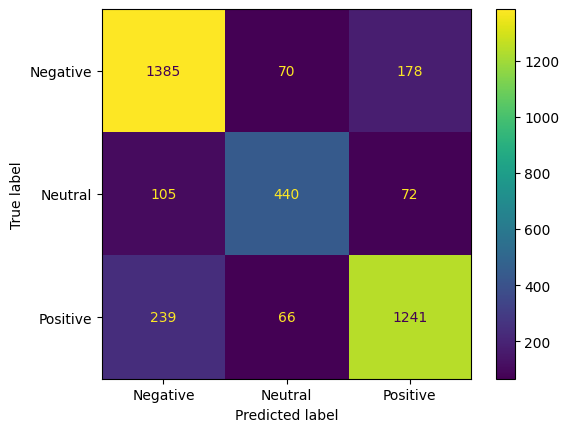

In [70]:
confusion_matrix_roberta = metrics.confusion_matrix(true_labels, pred_robert)
cm_display_roberta = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_roberta, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_roberta.plot()
plt.show()

In [71]:
import torch

output_model_file_roberta = 'pytorch_robert_sentiment.bin'
output_vocab_file_roberta = './'

model_to_save_roberta = roberta_model
torch.save(model_to_save_roberta, output_model_file_roberta)
tokenizer.save_vocabulary(output_vocab_file_roberta)

print('All files saved')

All files saved


## LSTM

In [111]:
train_x_LSTM = train_data["NewOriginalTweet"]
train_x_LSTM

0        advice talk neighbour family exchange phone nu...
1        coronavirus australia woolworth give elderly d...
2        food stock one empty please n't panic enough f...
3        ready go supermarket covid19 outbreak 'm paran...
4        news region first confirmed covid-19 case came...
                               ...                        
54127                                           one parent
54128         covid impacting online shopping behavior via
54129          think coronavirus symptom - consumer report
54130                      new signage local grocery store
54131    kedor selling beer price litre beer cost half ...
Name: NewOriginalTweet, Length: 54132, dtype: object

In [112]:
train_y_LSTM = train_data["target"]
train_y_LSTM

0        2
1        2
2        2
3        0
4        2
        ..
54127    1
54128    1
54129    1
54130    1
54131    1
Name: target, Length: 54132, dtype: int64

In [113]:
test_y_LSTM = test_data["target"]
test_y_LSTM

0       0
1       2
2       2
3       0
4       1
       ..
3791    2
3792    0
3793    1
3794    0
3795    2
Name: target, Length: 3796, dtype: int64

In [114]:
#ToString
test_x_LSTM = test_data['NewOriginalTweet']
test_x_LSTM = [str(sentence) for sentence in test_x_LSTM]

In [115]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_LSTM)

x_train_LSTM = tokenizer.texts_to_sequences(train_x_LSTM)

vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(train_x_LSTM[5]))
print("\nAfter tokenizing :\n{}".format(x_train_LSTM[5]))

x_train_LSTM = pad_sequences(x_train_LSTM, padding='post')
print("\nAfter padding :\n{}".format(x_train_LSTM[5]))

Vocabulary size: 36667

Example:

Sentence:
cashier grocery store wa sharing insight covid prove credibility commented `` 'm civics class know 'm talking ''

After tokenizing :
[538, 7, 4, 24, 1368, 474, 1, 2733, 10245, 9109, 146, 20399, 1017, 70, 146, 884, 43]

After padding :
[  538     7     4    24  1368   474     1  2733 10245  9109   146 20399
  1017    70   146   884    43     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [116]:
x_test = tokenizer.texts_to_sequences(test_x_LSTM)

print("\nExample:\n")
print("Sentence:\n{}".format(test_x_LSTM[5]))
print("\nAfter tokenizing :\n{}".format(x_test[5]))

x_test = pad_sequences(x_test, padding = 'post', maxlen = 40)
print("\nAfter padding :\n{}".format(x_test[5]))


Example:

Sentence:
remember last time paid gallon regular gas los angeles price pump going look coronavirus impacting price 4pm

After tokenizing :
[330, 113, 16, 478, 1018, 843, 131, 1921, 2510, 2, 1511, 33, 125, 3, 876, 2, 4615]

After padding :
[ 330  113   16  478 1018  843  131 1921 2510    2 1511   33  125    3
  876    2 4615    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [117]:
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
EMBEDDING_DIM = 16
units = 256

model = tf.keras.Sequential([
    layers.Embedding(vocab_size, EMBEDDING_DIM, input_length = x_train_LSTM.shape[1]),
    layers.Bidirectional(layers.LSTM(units, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.4),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(3)
])


model.compile(loss = SparseCategoricalCrossentropy(from_logits = True), optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 16)            586672    
                                                                 
 bidirectional (Bidirectiona  (None, 40, 512)          559104    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [118]:
LSTM = model.fit(x_train_LSTM, train_y_LSTM, epochs = EPOCHS, validation_split = 0.15, batch_size = BATCH_SIZE)

Epoch 1/2
1438/1438 [==============================] - 14468s 10s/step - loss: 0.7236 - accuracy: 0.6673 - val_loss: 0.5725 - val_accuracy: 0.8294
Epoch 2/2
1438/1438 [==============================] - 14492s 10s/step - loss: 0.3715 - accuracy: 0.8790 - val_loss: 0.3608 - val_accuracy: 0.8538


In [119]:
# Predict Output for LSTM
y_pred_LSTM = np.argmax(model.predict(x_test), axis=-1)

119/119 [==============================] - 361s 3s/step


In [120]:
print('\tClassification Report for LSTM :\n\n', classification_report(test_y_LSTM, y_pred_LSTM, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for LSTM :

               precision    recall  f1-score   support

    Negative       0.79      0.88      0.83      1633
     Neutral       0.86      0.74      0.80       617
    Positive       0.87      0.82      0.85      1546

    accuracy                           0.83      3796
   macro avg       0.84      0.81      0.83      3796
weighted avg       0.84      0.83      0.83      3796



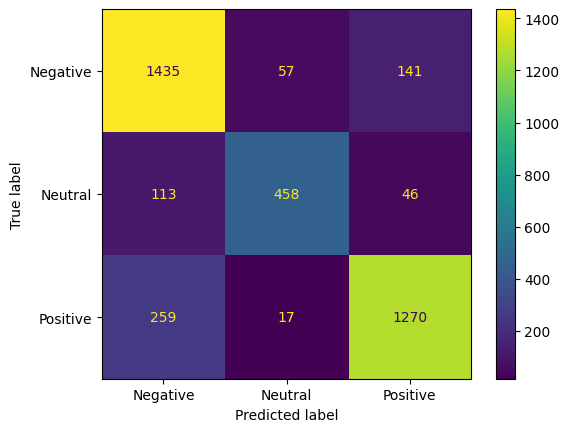

In [121]:
confusion_matrix_LSTM = metrics.confusion_matrix(test_y_LSTM, y_pred_LSTM)
cm_display_LSTM = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_LSTM, display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display_LSTM.plot()
plt.show()